# Networks Effect Investigation Tool

This notebook contains code to do the following:
- Load a csv file and pick a column
- Find daily changes over time
- Create a dataframe with two columns. Columns are rate of change for day t and t+1
- Plot the rows of the dataframe
- Fit the data ponts

Details about the method can be found in the textbook [Networks, Crowds, and Markets: Reasoning About a Highly Connected World](https://www.stat.berkeley.edu/~aldous/206-SNET/Papers/easley-kleinberg.pdf), Chapter 17.

In [22]:
# Parameters
FILE_NAME   = "2018.csv"
COLUMN_NAME = "Close"

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# surpress warnings
import warnings
warnings.filterwarnings('ignore')

# Helper Methods

def get_view_growth(viewCount):
    return (viewCount.shift(-1) - viewCount).dropna()

def get_z_hat_df(series):
    df = pd.DataFrame({'z':series, 'z_hat':series.shift(-1)})
    df = df.dropna()
    return df

get_line_method = lambda p: lambda x: p[0] * x + p[1]

def apply_p(p, series):
    l = len(p)
    sum = (series ** (l-1)) * p[0]
    for i in range(l-1):
        sum += (series ** (l-i-2)) * p [i+1]
    return sum

Below, you can see the loaded column:

In [24]:
df = pd.read_csv(FILE_NAME)
df[COLUMN_NAME]

0      5.2887
1      5.2725
2      5.2850
3      5.2761
4      5.3001
        ...  
256    3.7355
257    3.7476
258    3.7812
259    3.7667
260    3.7915
Name: Close, Length: 261, dtype: float64

Plotting the rows of the dataframe:

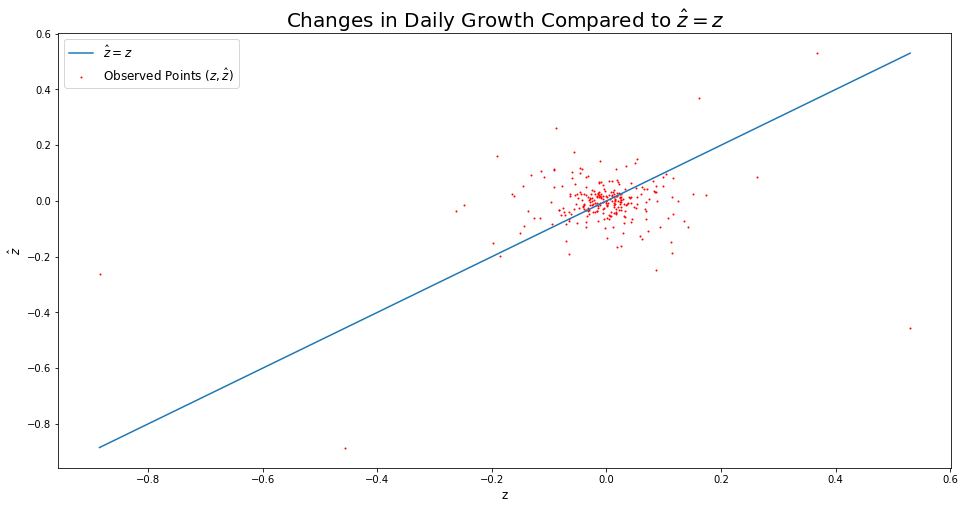

In [25]:
plt.figure(figsize=(16,8))

growth = get_view_growth(df[COLUMN_NAME])
growth_df = get_z_hat_df(growth)

line = get_line_method((1, 0))
interval = [f(growth) for f in [min, max]]

# plotting line
plt.plot(interval,
         [line(x) for x in interval],
         label = "$\hat{z}=z$")

# plotting dots
plt.scatter(growth_df['z'],
        growth_df['z_hat'],
        s = 1,
        color = 'red',
        label = "Observed Points $(z, \hat{z})$")

plt.legend(fontsize=12)
plt.title("Changes in Daily Growth Compared to $\hat{z}=z$", fontsize = 20)
plt.xlabel("z", fontsize = 12)
plt.ylabel("$\^{z}$", fontsize = 12)
plt.show()


Joining the dots using exponential smoothing:

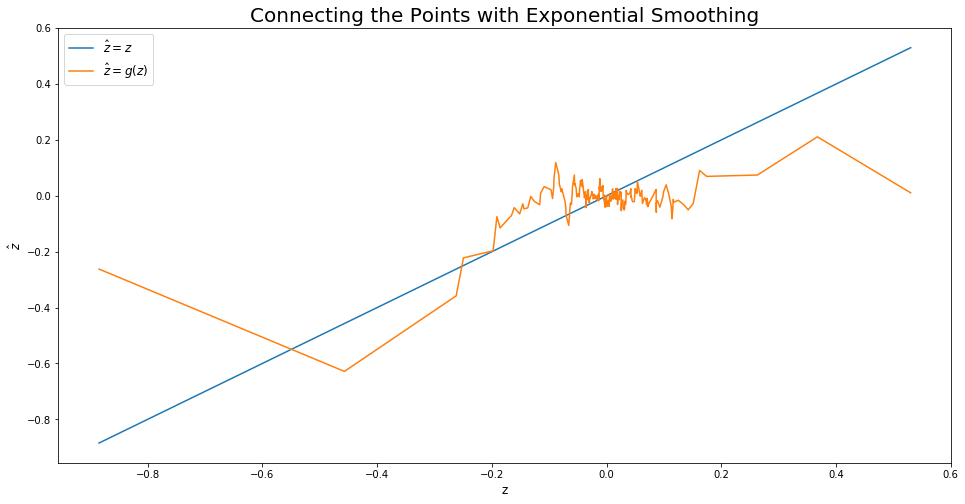

In [26]:
plt.figure(figsize=(16,8))

interval = [f(growth) for f in [min, max]]
plt.plot(interval,
         [line(x) for x in interval],
         label = "$\hat{z}=z$")

# exponential smoothing
growth_df_sorted = growth_df.sort_values(by="z")
plt.plot(growth_df_sorted['z'],
         growth_df_sorted['z_hat'].ewm(alpha=0.3).mean(),
         label = "$\hat{z} = g(z)$")

plt.legend(fontsize=12)
plt.title("Connecting the Points with Exponential Smoothing", fontsize = 20)
plt.xlabel("z", fontsize = 12)
plt.ylabel("$\^{z}$", fontsize = 12)
plt.show()

Fitting a regression model (Notice the DEGREE parameter):

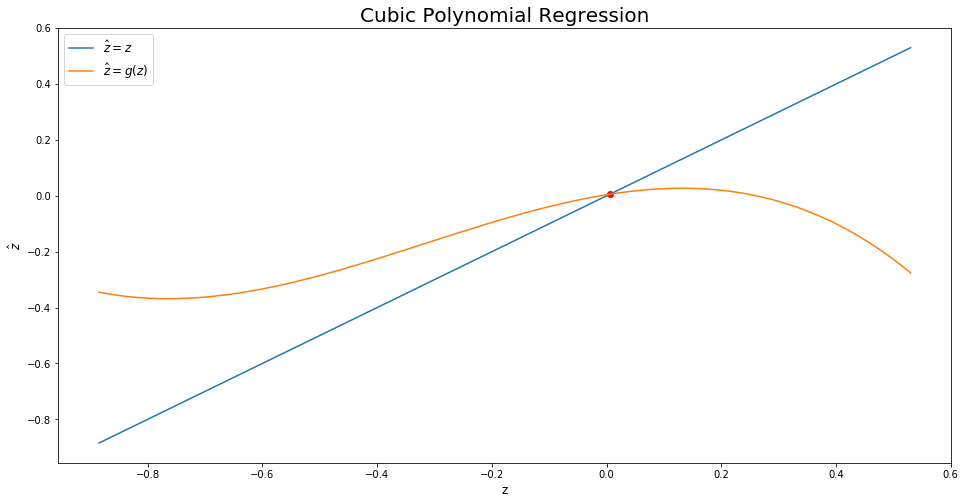

In [29]:
# PARAMETER
DEGREE = 3

# CODE
plt.figure(figsize=(16,8))

# plotting the z^=z line
interval = [f(growth) for f in [min, max]]
plt.plot(interval,
         [line(x) for x in interval],
         label = "$\hat{z}=z$")

growth_df_sorted = growth_df.sort_values(by="z")

# fitting a cubic polynomial and plotting it
p = np.polyfit(*[growth_df_sorted[c] for c in ['z', 'z_hat']], deg = DEGREE)
#z_hat = apply_p(p, growth_df_sorted['z'])
n_steps = 100
steps = np.linspace(*interval, n_steps)
z_hat = apply_p(p, steps)
#z_hat[z_hat < 0] = 0
plt.plot(steps,
         z_hat,
         label = "$\hat{z} = g(z)$")

# finding and plotting intersections
p[-2] -= 1
roots = np.roots(p)
real_roots = roots[((True^np.iscomplex(roots)) & (interval[0]<roots)) & (roots<interval[1])]
plt.scatter(real_roots, real_roots, color = 'red')

plt.legend(fontsize=12)
plt.title("Cubic Polynomial Regression", fontsize = 20)
plt.xlabel("z", fontsize = 12)
plt.ylabel("$\^{z}$", fontsize = 12)
plt.show()

Roots found:

In [28]:
real_roots.astype("float32")

array([-0.86025417, -0.34730956, -0.00732403], dtype=float32)